# Importing libraries and classes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from itertools import product
from tabulate import tabulate
from joblib import Parallel, delayed
from multiprocessing import Lock
from sklearn.metrics import median_absolute_error, max_error, mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.model_selection import train_test_split
from Utils import Utils

from DecisionTreeRegressor import DecisionTreeRegressor
from RandomForestRegressor import RandomForestRegressor
from LinearRegression import LinearRegression

# Reading and splitting the data

In [2]:
df = pd.read_csv('./NSO_Population_Sex_dataset/NSO_POPULATION_DATA_CLEANED.csv')

feature_cols = ['District', 'Sex', 'Year', 'Population_Growth_Rate','Average_Population']
X = pd.get_dummies(df[feature_cols], columns=['District', 'Sex'])
y = df["Population"]

Custom_Implementations_Number_Of_Runs = 5
NUM_CORES = 4

# Custom Implementations - Decision Tree, Random Forest, Linear Regression

In [3]:
# Decision Trees Hyperparameter tuning
Custom_Decision_Tree_Best_MSE_Over_Runs = float('inf')
Custom_Decision_Tree_Best_Parameters_Over_Runs = None

Custom_Decision_Tree_Parameters = {
    'min_samples_split': [2, 3, 4, 5, 10, 15, 20],
    'max_depth': [10, 25, 50, 75, 100, 125, 150, 175, 200]
}

for run in range(Custom_Implementations_Number_Of_Runs):
    # Reshuffling data before each run
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    # Initialise variables for each run
    Custom_Decision_Tree_Best_MSE = float('inf')
    Custom_Decision_Tree_Best_Parameters = None

    # Iterate over all combinations of Decision Tree hyperparameters
    for min_samples_split in Custom_Decision_Tree_Parameters['min_samples_split']:
        for max_depth in Custom_Decision_Tree_Parameters['max_depth']:
            # Instantiate and train your custom Decision Tree Regressor
            Custom_Decision_Tree_Regressor_Temp = DecisionTreeRegressor(min_samples_split=min_samples_split, max_depth=max_depth)
            Custom_Decision_Tree_Regressor_Temp.fit(X_train.values, y_train.values)

            # Make predictions
            Custom_Decision_Tree_Regressor_Temp_Predictions = Custom_Decision_Tree_Regressor_Temp.predict(X_test.values)

            # Calculate Mean Squared Error
            Custom_Decision_Tree_Regressor_Temp_MSE = mean_squared_error(y_test, Custom_Decision_Tree_Regressor_Temp_Predictions)

            # Check if current combination of hyperparameters gives a better result
            if Custom_Decision_Tree_Regressor_Temp_MSE < Custom_Decision_Tree_Best_MSE:
                Custom_Decision_Tree_Best_MSE = Custom_Decision_Tree_Regressor_Temp_MSE
                Custom_Decision_Tree_Best_Parameters = {'min_samples_split': min_samples_split, 'max_depth': max_depth}

    print(f"Run {run + 1}: Best Parameters - {Custom_Decision_Tree_Best_Parameters}, Best MSE - {Custom_Decision_Tree_Best_MSE}")

    if Custom_Decision_Tree_Best_MSE < Custom_Decision_Tree_Best_MSE_Over_Runs:
        Custom_Decision_Tree_Best_MSE_Over_Runs = Custom_Decision_Tree_Best_MSE
        Custom_Decision_Tree_Best_Parameters_Over_Runs = Custom_Decision_Tree_Best_Parameters

print(f"\nOverall Best Parameters - {Custom_Decision_Tree_Best_Parameters_Over_Runs}, Best MSE - {Custom_Decision_Tree_Best_MSE_Over_Runs}")

Run 1: Best Parameters - {'min_samples_split': 2, 'max_depth': 10}, Best MSE - 0.0002574154465311527
Run 2: Best Parameters - {'min_samples_split': 2, 'max_depth': 25}, Best MSE - 0.00014652069563634906
Run 3: Best Parameters - {'min_samples_split': 2, 'max_depth': 10}, Best MSE - 0.0005305236703404406
Run 4: Best Parameters - {'min_samples_split': 2, 'max_depth': 25}, Best MSE - 0.00041665091762091444
Run 5: Best Parameters - {'min_samples_split': 4, 'max_depth': 25}, Best MSE - 0.00027011986472426835

Overall Best Parameters - {'min_samples_split': 2, 'max_depth': 25}, Best MSE - 0.00014652069563634906


In [4]:
# Random Forest Hyperparameter Tuning
Custom_Random_Forest_Parameters = {
    'n_estimators': [50, 75, 100, 125],
    'min_samples_split': [2, 5, 10, 15],
    'max_depth': [25, 50, 75, 100]
}

# Create all combinations of hyperparameters
Custom_Random_Forest_Hyperparameter_Combinations = list(product(
    Custom_Random_Forest_Parameters['n_estimators'],
    Custom_Random_Forest_Parameters['min_samples_split'],
    Custom_Random_Forest_Parameters['max_depth']
))

# Function to train and evaluate the model for a specific parameter combination
def train_evaluate_model(params, X_train, y_train, X_test, y_test):
    n_estimators, min_sample_split, max_depth = params
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_sample_split)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    return mse, params

# Initialize the dictionary with default values
Custom_Random_Forest_Avg_MSE_Over_Parameters = {params: 0.0 for params in Custom_Random_Forest_Hyperparameter_Combinations}
best_params_over_runs = {'params': None, 'mse': float('inf')}

# Loop over runs
for run in range(Custom_Implementations_Number_Of_Runs):    
    # Reshuffling data before each run
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    # Parallelize the hyperparameter search
    results = Parallel(n_jobs=NUM_CORES)(delayed(train_evaluate_model)(params, X_train, y_train, X_test, y_test) 
                                          for params in Custom_Random_Forest_Hyperparameter_Combinations)

    # Accumulate MSE for each parameter combination
    for mse, params in results:
        Custom_Random_Forest_Avg_MSE_Over_Parameters[params] += mse

    # Find the best parameters for the current run
    best_params = min(results, key=lambda x: x[0])
    print(f"Run {run + 1}: Best Parameters - {best_params[1]}, Best MSE - {best_params[0]}")

    # Update overall best parameters
    if best_params[0] < best_params_over_runs['mse']:
        best_params_over_runs['params'] = best_params[1]
        best_params_over_runs['mse'] = best_params[0]

# Calculate the average MSE for each parameter combination
for params, total_mse in Custom_Random_Forest_Avg_MSE_Over_Parameters.items():
    Custom_Random_Forest_Avg_MSE_Over_Parameters[params] = total_mse / Custom_Implementations_Number_Of_Runs

# Find the best parameters based on the lowest average MSE
Custom_Random_Forest_Best_Parameters_Over_Runs = min(Custom_Random_Forest_Avg_MSE_Over_Parameters, key=Custom_Random_Forest_Avg_MSE_Over_Parameters.get)
print("\nOverall Best Random Forest Regressor Parameters based on average MSE over runs:", Custom_Random_Forest_Best_Parameters_Over_Runs)

Run 1: Best Parameters - (100, 2, 50), Best MSE - 0.0003146031267455865
Run 2: Best Parameters - (50, 10, 25), Best MSE - 0.00023317924396390292
Run 3: Best Parameters - (75, 2, 100), Best MSE - 0.0004254922208474779
Run 4: Best Parameters - (100, 2, 75), Best MSE - 0.0005172314116552474
Run 5: Best Parameters - (125, 15, 100), Best MSE - 0.00016889764412076702

Overall Best Random Forest Regressor Parameters based on average MSE over runs: (125, 2, 75)


In [5]:
# Linear Regression Hyperparameter tuning
Custom_Linear_Regression_Best_MSE_Over_Runs = float('inf')
Custom_Linear_Regression_Best_Parameters_Over_Runs = None

Custom_Linear_Regression_Parameters = {
    'learning_rate': [0.001, 0.01, 0.1, 1],
    'num_iterations': [50, 100, 250, 500, 750, 1000, 1250, 1500]
}

for run in range(Custom_Implementations_Number_Of_Runs):
    # Reshuffling data before each run
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Initialise variables for each run
    Custom_Linear_Regression_Best_MSE = float('inf')
    Custom_Linear_Regression_Best_Parameters = None

    # Iterate over all combinations of hyperparameters
    for learning_rate in Custom_Linear_Regression_Parameters['learning_rate']:
        for num_iterations in Custom_Linear_Regression_Parameters['num_iterations']:
            # Instantiate and train your custom Linear Regression
            Custom_Linear_Regression_Temp = LinearRegression(learning_rate=learning_rate, num_iterations=num_iterations)
            Custom_Linear_Regression_Temp.fit(X_train.values, y_train.values)

            # Make predictions
            Custom_Linear_Regression_Temp_Predictions = Custom_Linear_Regression_Temp.predict(X_test.values)

            # Calculate Mean Squared Error
            Custom_Linear_Regression_Temp_MSE = mean_squared_error(y_test, Custom_Linear_Regression_Temp_Predictions)

            # Check if the current combination of hyperparameters gives a better result
            if Custom_Linear_Regression_Temp_MSE < Custom_Linear_Regression_Best_MSE:
                Custom_Linear_Regression_Best_MSE = Custom_Linear_Regression_Temp_MSE
                Custom_Linear_Regression_Best_Parameters = {'learning_rate': learning_rate, 'num_iterations': num_iterations}

    print(f"Run {run + 1}: Best Parameters - {Custom_Linear_Regression_Best_Parameters}, Best MSE - {Custom_Linear_Regression_Best_MSE}")

    if Custom_Linear_Regression_Best_MSE < Custom_Linear_Regression_Best_MSE_Over_Runs:
        Custom_Linear_Regression_Best_MSE_Over_Runs = Custom_Linear_Regression_Best_MSE
        Custom_Linear_Regression_Best_Parameters_Over_Runs = Custom_Linear_Regression_Best_Parameters

print(f"\nOverall Best Parameters - {Custom_Linear_Regression_Best_Parameters_Over_Runs}, Best MSE - {Custom_Linear_Regression_Best_MSE_Over_Runs}")

Run 1: Best Parameters - {'learning_rate': 0.1, 'num_iterations': 1500}, Best MSE - 0.00266687398154362
Run 2: Best Parameters - {'learning_rate': 0.1, 'num_iterations': 1500}, Best MSE - 0.003500355640505739
Run 3: Best Parameters - {'learning_rate': 0.1, 'num_iterations': 250}, Best MSE - 0.0024686408038208283
Run 4: Best Parameters - {'learning_rate': 0.1, 'num_iterations': 1500}, Best MSE - 0.004036875484702333
Run 5: Best Parameters - {'learning_rate': 0.1, 'num_iterations': 250}, Best MSE - 0.0028814589972989404

Overall Best Parameters - {'learning_rate': 0.1, 'num_iterations': 250}, Best MSE - 0.0024686408038208283


In [12]:
# Reshuffling data before run
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Small constant to avoid division by very small values
MBD_Denominator = np.where(np.abs(y_test) > 1e-10, y_test, 1e-10) 

# Each algorithm has the parameters set according to the best found through their corresponding hyperparameter tuning
# Decision Tree Regressor
start_time = time.time()
Custom_Decision_Tree_Regressor = DecisionTreeRegressor(min_samples_split=Custom_Decision_Tree_Best_Parameters_Over_Runs['min_samples_split'], max_depth=Custom_Decision_Tree_Best_Parameters_Over_Runs['max_depth'])
Custom_Decision_Tree_Regressor.fit(X_train.values, y_train.values)
Custom_Decision_Tree_Regressor_Prediction = Custom_Decision_Tree_Regressor.predict(X_test.values)
end_time = time.time()
Custom_Decision_Tree_Regressor_Time = end_time - start_time
Custom_Decision_Tree_Regressor_Prediction_MAE = mean_absolute_error(y_test, Custom_Decision_Tree_Regressor_Prediction)  # Mean Absolute Error
Custom_Decision_Tree_Regressor_Prediction_MSE = mean_squared_error(y_test, Custom_Decision_Tree_Regressor_Prediction)  # Mean Squared Error
Custom_Decision_Tree_Regressor_Prediction_RMSE = Utils.root_mean_squared_error(y_test, Custom_Decision_Tree_Regressor_Prediction)  # Root Mean Squared Error
Custom_Decision_Tree_Regressor_Prediction_R2 = r2_score(y_test, Custom_Decision_Tree_Regressor_Prediction)  # R-squared
Custom_Decision_Tree_Regressor_MAPE = np.mean(np.abs((y_test - Custom_Decision_Tree_Regressor_Prediction) / y_test)) * 100  # Mean Absolute Percentage Error
Custom_Decision_Tree_Regressor_SMAPE = 2 * np.mean(np.abs(y_test - Custom_Decision_Tree_Regressor_Prediction) / (np.abs(y_test) + np.abs(Custom_Decision_Tree_Regressor_Prediction))) * 100  # Symmetric Mean Absolute Percentage Error
Custom_Decision_Tree_Regressor_Explained_Variance = explained_variance_score(y_test, Custom_Decision_Tree_Regressor_Prediction)  # Explained Variance Score
Custom_Decision_Tree_Regressor_MedianAE = median_absolute_error(y_test, Custom_Decision_Tree_Regressor_Prediction)  # Median Absolute Error
Custom_Decision_Tree_Regressor_MBD = np.mean((y_test - Custom_Decision_Tree_Regressor_Prediction) / MBD_Denominator) * 100  # Mean Bias Deviation
Custom_Decision_Tree_Regressor_MaxError = max_error(y_test, Custom_Decision_Tree_Regressor_Prediction)  # Maximum Error

# Random Forest Regressor
start_time = time.time()
Custom_Random_Forest_Regressor = RandomForestRegressor(n_estimators=Custom_Random_Forest_Best_Parameters_Over_Runs[0], max_depth=Custom_Random_Forest_Best_Parameters_Over_Runs[1], min_samples_split=Custom_Random_Forest_Best_Parameters_Over_Runs[2])
Custom_Random_Forest_Regressor.fit(X_train, y_train)
Custom_Random_Forest_Regressor_Prediction = Custom_Random_Forest_Regressor.predict(X_test)
end_time = time.time()
Custom_Random_Forest_Regressor_Time = end_time - start_time
Custom_Random_Forest_Regressor_MAE = mean_absolute_error(y_test, Custom_Random_Forest_Regressor_Prediction)  # Mean Absolute Error
Custom_Random_Forest_Regressor_MSE = mean_squared_error(y_test, Custom_Random_Forest_Regressor_Prediction)  # Mean Squared Error
Custom_Random_Forest_Regressor_RMSE = Utils.root_mean_squared_error(y_test, Custom_Random_Forest_Regressor_Prediction)  # Root Mean Squared Error
Custom_Random_Forest_Regressor_R2 = r2_score(y_test, Custom_Random_Forest_Regressor_Prediction)  # R-squared
Custom_Random_Forest_Regressor_MAPE = np.mean(np.abs((y_test - Custom_Random_Forest_Regressor_Prediction) / y_test)) * 100  # Mean Absolute Percentage Error
Custom_Random_Forest_Regressor_SMAPE = 2 * np.mean(np.abs(y_test - Custom_Random_Forest_Regressor_Prediction) / (np.abs(y_test) + np.abs(Custom_Random_Forest_Regressor_Prediction))) * 100  # Symmetric Mean Absolute Percentage Error
Custom_Random_Forest_Regressor_Explained_Variance = explained_variance_score(y_test, Custom_Random_Forest_Regressor_Prediction)  # Explained Variance Score
Custom_Random_Forest_Regressor_MedianAE = median_absolute_error(y_test, Custom_Random_Forest_Regressor_Prediction)  # Median Absolute Error
Custom_Random_Forest_Regressor_MBD = np.mean((y_test - Custom_Random_Forest_Regressor_Prediction) / MBD_Denominator) * 100  # Mean Bias Deviation
Custom_Random_Forest_Regressor_MaxError = max_error(y_test, Custom_Random_Forest_Regressor_Prediction)  # Maximum Error

# Linear Regression
start_time = time.time()
Custom_Linear_Regression = LinearRegression(learning_rate=Custom_Linear_Regression_Best_Parameters_Over_Runs['learning_rate'], num_iterations=Custom_Linear_Regression_Best_Parameters_Over_Runs['num_iterations'])
Custom_Linear_Regression.fit(X_train.values, y_train.values)
Custom_Linear_Regression_Prediction = Custom_Linear_Regression.predict(X_test)
end_time = time.time()
Custom_Linear_Regression_Time = end_time - start_time
Custom_Linear_Regression_MAE = mean_absolute_error(y_test, Custom_Linear_Regression_Prediction)  # Mean Absolute Error
Custom_Linear_Regression_MSE = mean_squared_error(y_test, Custom_Linear_Regression_Prediction)  # Mean Squared Error
Custom_Linear_Regression_RMSE = Utils.root_mean_squared_error(y_test, Custom_Linear_Regression_Prediction)  # Root Mean Squared Error
Custom_Linear_Regression_R2 = r2_score(y_test, Custom_Linear_Regression_Prediction)  # R-squared
Custom_Linear_Regression_MAPE = np.mean(np.abs((y_test - Custom_Linear_Regression_Prediction) / y_test)) * 100  # Mean Absolute Percentage Error
Custom_Linear_Regression_SMAPE = 2 * np.mean(np.abs(y_test - Custom_Linear_Regression_Prediction) / (np.abs(y_test) + np.abs(Custom_Linear_Regression_Prediction))) * 100  # Symmetric Mean Absolute Percentage Error
Custom_Linear_Regression_MedianAE = median_absolute_error(y_test, Custom_Linear_Regression_Prediction)  # Median Absolute Error
Custom_Linear_Regression_Explained_Variance = explained_variance_score(y_test, Custom_Linear_Regression_Prediction)  # Explained Variance Score
Custom_Linear_Regression_MBD = np.mean((y_test - Custom_Linear_Regression_Prediction) / MBD_Denominator) * 100  # Mean Bias Deviation
Custom_Linear_Regression_MaxError = max_error(y_test, Custom_Linear_Regression_Prediction)  # Maximum Error

# Print time taken for each algorithm
print("Time taken for Decision Tree Regressor: {:.4f} seconds".format(Custom_Decision_Tree_Regressor_Time))
print("Time taken for Random Forest Regressor: {:.4f} seconds".format(Custom_Random_Forest_Regressor_Time))
print("Time taken for Linear Regression: {:.4f} seconds".format(Custom_Linear_Regression_Time))

Time taken for Decision Tree Regressor: 0.4485 seconds
Time taken for Random Forest Regressor: 11.6035 seconds
Time taken for Linear Regression: 0.5655 seconds


# Scatter Plot - Actual vs Predicted values

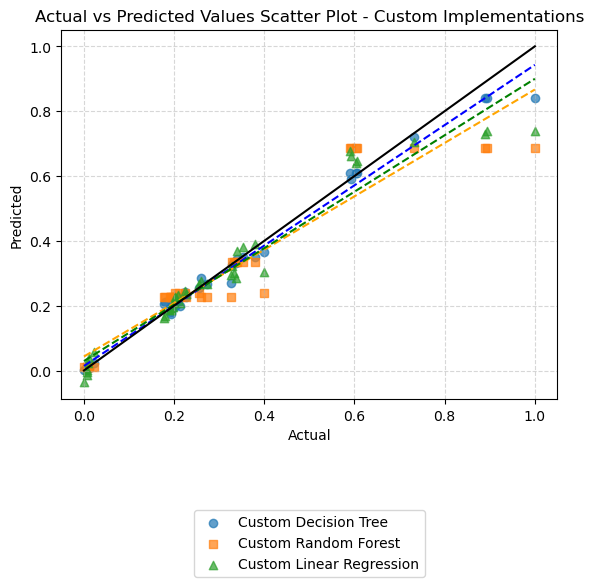

In [13]:
# Custom Decision Tree vs Custom Random Forest vs Custom Linear Regression
y_test_numeric = np.asarray(y_test, dtype=np.float64)
Custom_Decision_Tree_Regressor_Prediction_Numeric = np.asarray(Custom_Decision_Tree_Regressor_Prediction, dtype=np.float64)
Custom_Random_Forest_Regressor_Prediction_Numeric = np.asarray(Custom_Random_Forest_Regressor_Prediction, dtype=np.float64)
Custom_Linear_Regression_Prediction_Numeric = np.asarray(Custom_Linear_Regression_Prediction, dtype=np.float64)

plt.scatter(y_test, Custom_Decision_Tree_Regressor_Prediction_Numeric, alpha=0.7, marker='o', label='Custom Decision Tree')
plt.scatter(y_test, Custom_Random_Forest_Regressor_Prediction_Numeric, alpha=0.7, marker='s', label='Custom Random Forest')
plt.scatter(y_test, Custom_Linear_Regression_Prediction_Numeric, alpha=0.7, marker='^', label='Custom Linear Regression')

# Regression lines
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, Custom_Decision_Tree_Regressor_Prediction_Numeric, 1))(np.unique(y_test)), color='blue', linestyle='--')
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, Custom_Random_Forest_Regressor_Prediction_Numeric, 1))(np.unique(y_test)), color='orange', linestyle='--')
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, Custom_Linear_Regression_Prediction_Numeric, 1))(np.unique(y_test)), color='green', linestyle='--')

# Reference line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='-', color='black')

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values Scatter Plot - Custom Implementations')

plt.legend(['Custom Decision Tree', 'Custom Random Forest', 'Custom Linear Regression'], loc='lower center', bbox_to_anchor=(0.5,-0.5))
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Line Plot - Actual vs Predicted values

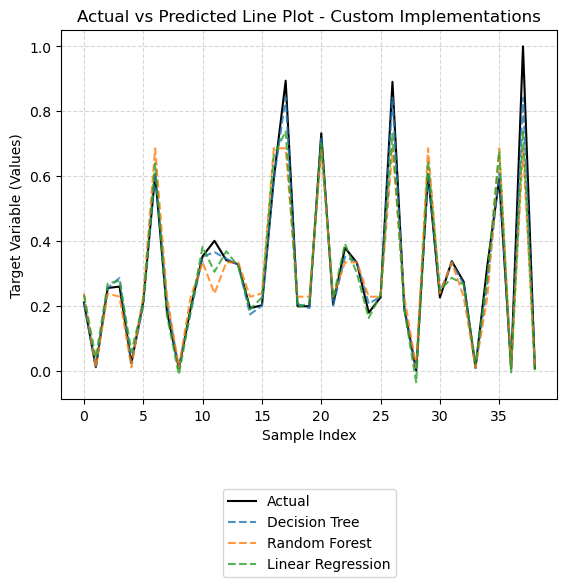

In [14]:
# Custom Decision Tree vs Custom Random Forest vs Custom Linear Regression
plt.plot(y_test.values, label='Actual', color='black', linestyle='-')
plt.plot(Custom_Decision_Tree_Regressor_Prediction, label='Decision Tree', alpha=0.8, linestyle='--')
plt.plot(Custom_Random_Forest_Regressor_Prediction, label='Random Forest', alpha=0.8, linestyle='--')
plt.plot(Custom_Linear_Regression_Prediction, label='Linear Regression', alpha=0.8, linestyle='--')
plt.xlabel('Sample Index')
plt.ylabel('Target Variable (Values)')
plt.title('Actual vs Predicted Line Plot - Custom Implementations')
plt.legend(loc='lower center', bbox_to_anchor=(0.5,-0.5))
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Residual Plots

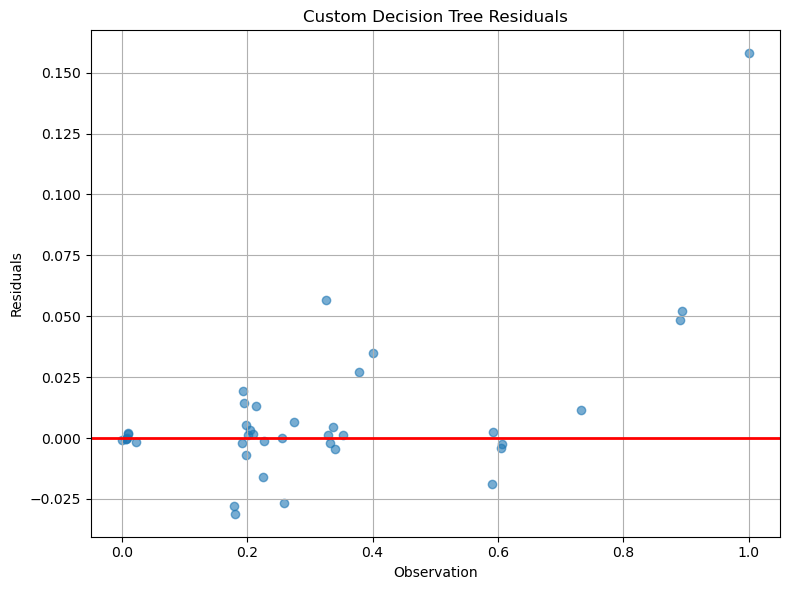

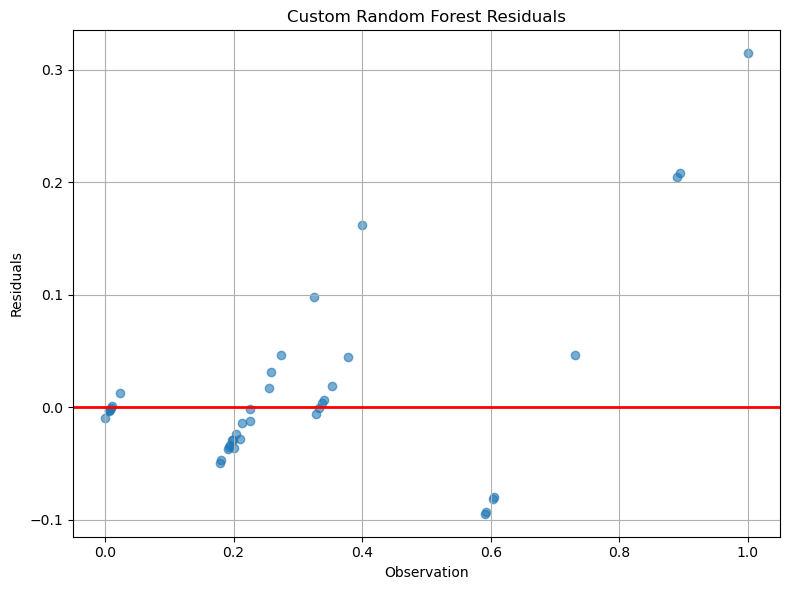

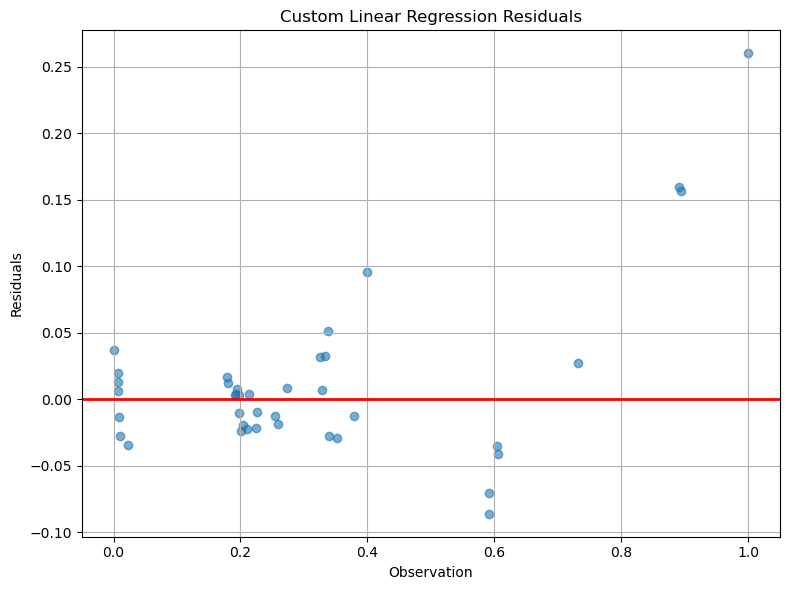

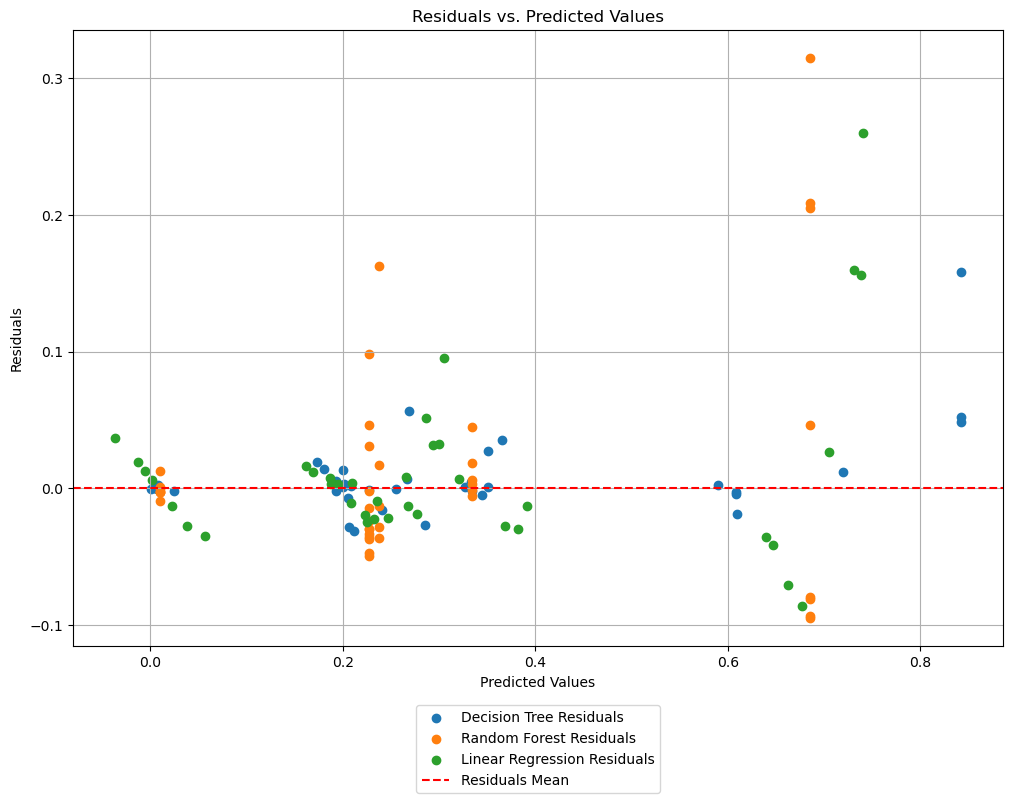

In [15]:
custom_decision_tree_residuals = y_test - Custom_Decision_Tree_Regressor_Prediction
custom_random_forest_residuals = y_test - Custom_Random_Forest_Regressor_Prediction
custom_linear_regression_residuals = y_test - Custom_Linear_Regression_Prediction

# Plot for Custom Decision Tree
plt.figure(figsize=(8, 6))
plt.scatter(y_test, custom_decision_tree_residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='-', linewidth=2)
plt.grid(True)
plt.xlabel('Observation')
plt.ylabel('Residuals')
plt.title('Custom Decision Tree Residuals')
plt.tight_layout()
plt.show()

# Plot for Custom Random Forest
plt.figure(figsize=(8, 6))
plt.scatter(y_test, custom_random_forest_residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='-', linewidth=2)
plt.grid(True)
plt.xlabel('Observation')
plt.ylabel('Residuals')
plt.title('Custom Random Forest Residuals')
plt.tight_layout()
plt.show()

# Plot for Custom Linear Regression
plt.figure(figsize=(8, 6))
plt.scatter(y_test, custom_linear_regression_residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='-', linewidth=2)
plt.grid(True)
plt.xlabel('Observation')
plt.ylabel('Residuals')
plt.title('Custom Linear Regression Residuals')
plt.tight_layout()
plt.show()

# Residuals vs. Predicted Values for all models
plt.figure(figsize=(12, 8))
plt.scatter(Custom_Decision_Tree_Regressor_Prediction, custom_decision_tree_residuals, label='Decision Tree Residuals')
plt.scatter(Custom_Random_Forest_Regressor_Prediction, custom_random_forest_residuals, label='Random Forest Residuals')
plt.scatter(Custom_Linear_Regression_Prediction, custom_linear_regression_residuals, label='Linear Regression Residuals')
plt.axhline(y=0, color='r', linestyle='--', label='Residuals Mean')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.legend(loc='lower center', bbox_to_anchor=(0.5,-0.25))
plt.grid(True)
plt.show()

# Mean Absolute Error, Mean Squared Error, Root Mean Squared Error, R Squared, Cross-Validation, Explained Variance

In [16]:
table_data = {
    '': ['Custom Decision Tree Regressor', 'Custom Random Forest Regressor', 'Custom Linear Regression'],
    'Mean Absolute Error (MAE)': [Custom_Decision_Tree_Regressor_Prediction_MAE, Custom_Random_Forest_Regressor_MAE, Custom_Linear_Regression_MAE],
    'Median Absolute Error (MedianAE)': [Custom_Decision_Tree_Regressor_MedianAE, Custom_Random_Forest_Regressor_MedianAE, Custom_Linear_Regression_MedianAE],
    'Mean Squared Error (MSE)': [Custom_Decision_Tree_Regressor_Prediction_MSE, Custom_Random_Forest_Regressor_MSE, Custom_Linear_Regression_MSE],
    'Root Mean Squared Error (RMSE)': [Custom_Decision_Tree_Regressor_Prediction_RMSE, Custom_Random_Forest_Regressor_RMSE, Custom_Linear_Regression_RMSE],
    'R Squared (R\u00b2)': [Custom_Decision_Tree_Regressor_Prediction_R2, Custom_Random_Forest_Regressor_R2, Custom_Linear_Regression_R2],
    'Explained Variance': [Custom_Decision_Tree_Regressor_Explained_Variance, Custom_Random_Forest_Regressor_Explained_Variance, Custom_Linear_Regression_Explained_Variance],
    'Mean Bias Deviation (MBD)': [Custom_Decision_Tree_Regressor_MBD, Custom_Random_Forest_Regressor_MBD, Custom_Linear_Regression_MBD],
    'Maximum Error': [Custom_Decision_Tree_Regressor_MaxError, Custom_Random_Forest_Regressor_MaxError, Custom_Linear_Regression_MaxError],
    'Mean Absolute Percentage Error (MAPE)': [Custom_Decision_Tree_Regressor_MAPE, Custom_Random_Forest_Regressor_MAPE, Custom_Linear_Regression_MAPE],
    'Symmetric Mean Absolute Percentage Error (SMAPE)': [Custom_Decision_Tree_Regressor_SMAPE, Custom_Random_Forest_Regressor_SMAPE, Custom_Linear_Regression_SMAPE]
}

print(tabulate(table_data, headers='keys', tablefmt='fancy_grid'))

╒════════════════════════════════╤═════════════════════════════╤════════════════════════════════════╤════════════════════════════╤══════════════════════════════════╤══════════════════╤══════════════════════╤═════════════════════════════╤═════════════════╤═════════════════════════════════════════╤════════════════════════════════════════════════════╕
│                                │   Mean Absolute Error (MAE) │   Median Absolute Error (MedianAE) │   Mean Squared Error (MSE) │   Root Mean Squared Error (RMSE) │   R Squared (R²) │   Explained Variance │   Mean Bias Deviation (MBD) │   Maximum Error │   Mean Absolute Percentage Error (MAPE) │   Symmetric Mean Absolute Percentage Error (SMAPE) │
╞════════════════════════════════╪═════════════════════════════╪════════════════════════════════════╪════════════════════════════╪══════════════════════════════════╪══════════════════╪══════════════════════╪═════════════════════════════╪═════════════════╪═════════════════════════════════════════╪═

# Actual vs Predicted Values

╒═════════════════╤══════════════════════════════════╤══════════════════════════════════╤════════════════════════════╕
│   Actual Values │   Custom Decision Tree Regressor │   Custom Random Forest Regressor │   Custom Linear Regression │
╞═════════════════╪══════════════════════════════════╪══════════════════════════════════╪════════════════════════════╡
│      0.612186   │                       0.611689   │                       0.699084   │                 0.676012   │
├─────────────────┼──────────────────────────────────┼──────────────────────────────────┼────────────────────────────┤
│      0.178442   │                       0.18197    │                       0.229003   │                 0.156024   │
├─────────────────┼──────────────────────────────────┼──────────────────────────────────┼────────────────────────────┤
│      0.894065   │                       0.90776    │                       0.699084   │                 0.75731    │
├─────────────────┼─────────────────────────────

f:\AnacondaNavigator\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
f:\AnacondaNavigator\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
f:\AnacondaNavigator\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
f:\AnacondaNavigator\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('

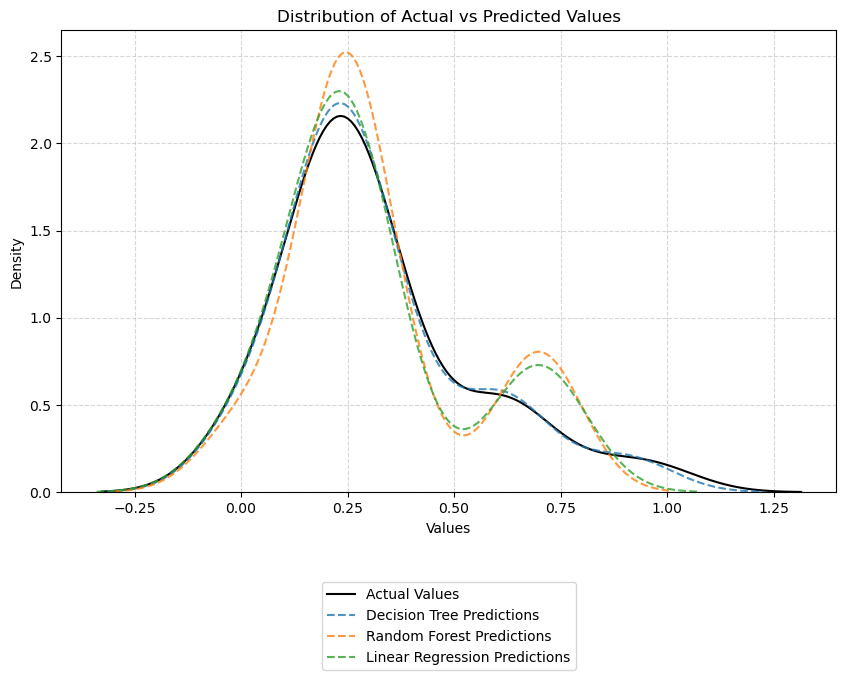

In [ ]:
results_table_data = {
    'Actual Values': y_test,
    'Custom Decision Tree Regressor': Custom_Decision_Tree_Regressor_Prediction,
    'Custom Random Forest Regressor': Custom_Random_Forest_Regressor_Prediction,
    'Custom Linear Regression': Custom_Linear_Regression_Prediction
}

print(tabulate(results_table_data, headers='keys', tablefmt='fancy_grid'))

plt.figure(figsize=(10, 6))
sns.kdeplot(y_test, label='Actual Values', color='black', linestyle='-')
sns.kdeplot(Custom_Decision_Tree_Regressor_Prediction, label='Decision Tree Predictions', alpha=0.8, linestyle='--')
sns.kdeplot(Custom_Random_Forest_Regressor_Prediction, label='Random Forest Predictions', alpha=0.8, linestyle='--')
sns.kdeplot(Custom_Linear_Regression_Prediction, label='Linear Regression Predictions', alpha=0.8, linestyle='--')
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Distribution of Actual vs Predicted Values')
plt.legend(loc='lower center', bbox_to_anchor=(0.5,-0.4))
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()